## Easy 21
### Imports

In [309]:
import numpy as np
import matplotlib.pyplot as plt

### Environment

In [310]:
def sample_card():
    value = random.randrange(1, 11)
    factor = 1 if random.random() < 0.7 else -1
    return value * factor

def is_busted(cards):
    return cards < 1 or cards > 21

def final_reward(state):
    if state[0] == state[1]:
        return 0
    elif state[0] < state[1]:
        return 1
    else:
        return -1

def reward(state):
    if is_busted(state[0]):
        return 1
    elif is_busted(state[1]):
        return -1
    else:
        if state[2]:
            return final_reward(state)
        else:
            return 0
        
def next_state(state, action):
    if state[2]:
        return state
    else:
        if action == 0:
            player =  state[1] + sample_card()
            return (state[0], player, is_busted(player))
        elif action == 1:
            while(not state[2] and state[0] < 17):
                dealer = state[0] + sample_card()
                state = (dealer, state[1], is_busted(dealer))
            return (state[0], state[1], True)
        else:
            return state

def initial_state():
    return (random.randrange(1, 11), random.randrange(1, 11), False)
        
def step(state, action):
    state = next_state(state, action)
    return (state, reward(state))

### Monte Carlo Control

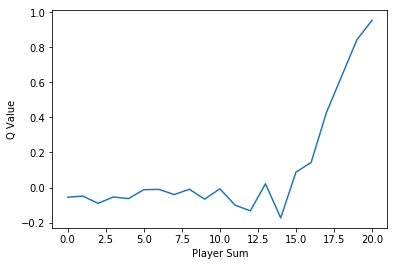

In [381]:
n_0 = 100
n_t = np.zeros((10,21))
n_values = np.zeros((10,21,2))
q_values = np.zeros((10,21,2))

def sample_episode():
    state = initial_state()
    episode = []
    while(not state[2]):
        epsilon = n_0 / (n_0 + n_t[(state[0]-1, state[1]-1)])
        action = e_greedy(epsilon, state)
        next_state, reward = step(state, action)
        episode.append((state, action, reward))
        state = next_state
    return episode

def e_greedy(epsilon, state):
    max_action = np.argmax(q_values[(state[0]-1, state[1]-1)])
    random_action = random.randrange(2)
    return max_action if random.random() > epsilon else random_action

def update_values(episode):
    g = sum(map(lambda e: e[2], episode))
    for (s,a,r) in episode:
        n_t[(s[0]-1, s[1]-1)] += 1
        n_values[(s[0]-1, s[1]-1, a)] += 1
        q_values[(s[0]-1, s[1]-1, a)] += (1 / n_values[(s[0]-1, s[1]-1, a)]) * (g - q_values[(s[0]-1, s[1]-1, a)])
        g -= r
        
def monte_carlo_control(n_iterations):
    for i in range(n_iterations):
        episode = sample_episode()
        update_values(episode)

monte_carlo_control(10000)
plt.plot(np.arange(21), np.amax(np.average(q_values, axis=0), axis=1))
plt.xlabel('Player Sum')
plt.ylabel('Q Value')
plt.show()